In [1]:
import pandas as pd
import numpy as np

Read in filtered data.

In [2]:
devices_filtered = pd.read_csv("../devices.csv")
encounter_filtered = pd.read_csv("../Cleaned_datasets/encounter_filtered.csv")
bloodgas_filtered = pd.read_csv("../Cleaned_datasets/bloodgas_filtered.csv")
patient_filtered = pd.read_csv("../Cleaned_datasets/patient_filtered.csv")
pulseox_filtered = pd.read_csv("../Cleaned_datasets/pulseox_filtered.csv")
spectrophotometer_filtered = pd.read_csv("../Cleaned_datasets/spectrophotometer_filtered.csv")

Merge bloodgas and pulseox based on `encounter_id` and `sample_number`. To compare `saturation` and `so2` values. 

In [3]:
bloodgas_pulseox=pulseox_filtered.merge(bloodgas_filtered,on=['encounter_id','sample_number'],how='inner')

Average the values in each list for `saturation` and `so2_filled` to compare. Ensuring all values are converted from string to float if necessary.

In [4]:
import ast

def parse_list_from_string(lst):
    if isinstance(lst, str):
        try:
            # Convert string representation of list to actual list
            return ast.literal_eval(lst)
        except:
            return []
    return lst  # already a list
bloodgas_pulseox['saturation'] = bloodgas_pulseox['saturation'].apply(parse_list_from_string)
bloodgas_pulseox['so2_filled'] = bloodgas_pulseox['so2_filled'].apply(parse_list_from_string)
bloodgas_pulseox['ScalcO2'] = bloodgas_pulseox['ScalcO2'].apply(parse_list_from_string)

def to_float_list(lst):
    floats = []
    for x in lst:
        try:
            floats.append(float(x))
        except (ValueError, TypeError):
            continue  # skip invalid entries like 'very unstable'
    return floats

bloodgas_pulseox['saturation'] = bloodgas_pulseox['saturation'].apply(to_float_list)
bloodgas_pulseox['so2_filled'] = bloodgas_pulseox['so2_filled'].apply(to_float_list)
bloodgas_pulseox['ScalcO2'] = bloodgas_pulseox['ScalcO2'].apply(to_float_list)

import numpy as np

def safe_mean(lst):
    if len(lst) == 0:
        return np.nan
    return np.nanmean(lst)

bloodgas_pulseox['saturation_mean'] = bloodgas_pulseox['saturation'].apply(safe_mean)
bloodgas_pulseox['so2_mean'] = bloodgas_pulseox['so2_filled'].apply(safe_mean)


Compare the mean values for `saturation` and `so2` 

In [5]:
bloodgas_pulseox['oxy_sat_comparison'] = bloodgas_pulseox['saturation_mean']-bloodgas_pulseox['so2_mean']

Filter out unwanted columns.

In [6]:
retain_columns=['encounter_id','sample_number','saturation','so2_filled','saturation_mean','so2_mean','oxy_sat_comparison']
bloodgas_pulseox_filtered=bloodgas_pulseox[retain_columns]

Merged to get fitzpatrick value (I-VI) displayed in the column as (1.0-6.0).

In [7]:
# Keep only 'encounter_id' and 'fitzpatrick' from encounter_filtered
fitz_df = encounter_filtered[['encounter_id', 'fitzpatrick']]

# Merge with bloodgas_pulseox_filtered on 'encounter_id'
fitz_merged = bloodgas_pulseox_filtered.merge(fitz_df, on='encounter_id', how='left')
fitz_merged.to_csv('fitz_merged.csv', index=False)

Now analyze the difference across skin tones using an ANOVA test.

In [8]:
import scipy.stats as stats

groups = [group['oxy_sat_comparison'].values for name, group in fitz_merged.groupby('fitzpatrick')]
F, p = stats.f_oneway(*groups)
print("ANOVA F-statistic:", F)
print("p-value:", p)

ANOVA F-statistic: 293.24300107373114
p-value: 1.5923400315469787e-301


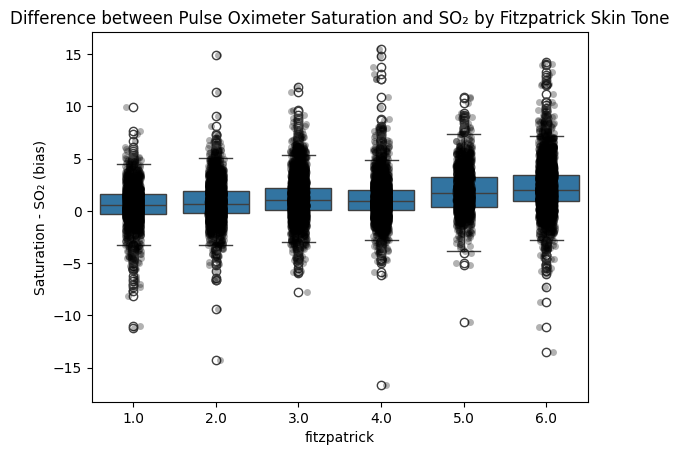

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fitzpatrick', y='oxy_sat_comparison', data=fitz_merged)
sns.stripplot(x='fitzpatrick', y='oxy_sat_comparison', data=fitz_merged, color='black', alpha=0.3)
plt.title('Difference between Pulse Oximeter Saturation and SO₂ by Fitzpatrick Skin Tone')
plt.ylabel('Saturation - SO₂ (bias)')
plt.show()


Create 6 dataframes grouped their fitzpatrick value. Write those values to `Skin Tone Analysis` folder as a csv.

In [10]:
# Assuming 'fitzpatrick' column is numeric (1.0–6.0)
df1 = fitz_merged[fitz_merged['fitzpatrick'] == 1.0].copy()
df2 = fitz_merged[fitz_merged['fitzpatrick'] == 2.0].copy()
df3 = fitz_merged[fitz_merged['fitzpatrick'] == 3.0].copy()
df4 = fitz_merged[fitz_merged['fitzpatrick'] == 4.0].copy()
df5 = fitz_merged[fitz_merged['fitzpatrick'] == 5.0].copy()
df6 = fitz_merged[fitz_merged['fitzpatrick'] == 6.0].copy()

In [11]:
df1.to_csv('fitz_1.csv', index=False)
df2.to_csv('fitz_2.csv', index=False)
df3.to_csv('fitz_3.csv', index=False)
df4.to_csv('fitz_4.csv', index=False)
df5.to_csv('fitz_5.csv', index=False)
df6.to_csv('fitz_6.csv', index=False)

Create dictionary of `encounter_id` values based on fitzpatrick values (skin tone scale I-VI) and return the corresponding encounter ids.

In [12]:
# mapping Fitzpatrick numeric value → Roman numeral label
fitz_labels = {
    1.0: 'I',
    2.0: 'II',
    3.0: 'III',
    4.0: 'IV',
    5.0: 'V',
    6.0: 'VI'
}

# initialize dictionary to hold lists of encounter_ids per Fitzpatrick group
fitz_dict = {}

for value, label in fitz_labels.items():
    ids = encounter_filtered.loc[encounter_filtered['fitzpatrick'] == value, 'encounter_id'].tolist()
    fitz_dict[label] = [ids]  # wrap in list so we can create a 1-row DataFrame

# create the summary DataFrame
fitz_summary_df = pd.DataFrame(fitz_dict)

# display result
print(fitz_summary_df)

                                                   I  \
0  [023153e2349d0b1fd2677b51e963194f83fe919e52c12...   

                                                  II  \
0  [02e24eaa40d54789d77fb67c3258f1f9e26f48764b254...   

                                                 III  \
0  [01a542fef90c977867f1016bb46772e233006183c5c87...   

                                                  IV  \
0  [02093f14af09488db9e650db6130e55e214c1831adf4f...   

                                                   V  \
0  [01b0a887f76a3f77a708ccff97cabb16b223e572c4bfd...   

                                                  VI  
0  [02c37e54017643ceb7b0a9cdc05348c6737a1aa6434d0...  


Store data dictionary as a json file to use to retrieve corresponding waveforms.

In [15]:
import json


# Save the dictionary to a JSON file
with open("fitz_dict.json", "w") as f:
    json.dump(fitz_dict, f, indent=4) # indent for pretty printing